# Indoor Climbing Hold Segmentation

This Jupyter notebook is an interactive overview of the major components of https://github.com/xiaoxiae/Hei-CV-Final-2022-23.

Before running the repository, make sure you have downloaded the appropriate datasets from https://www.kaggle.com/tomasslama/indoor-climbing-gym-hold-segmentation and placed them in their respective folders in `data/`.
Also make sure that you have installed the required Python packages, which can be found in `requirements.txt` (i.e. `python3 -m pip install -r requirements.txt`).

## Hold Segmentation

### Standard Approach

The standard approach can be broadly separated into the following parts:
1. detect blobs, which are centers of holds
2. detect edges, which are outlines of holds
3. for each blob, find a threshold such that the contour fits the outline

Each of the functions that process the images are configured with sane defaults, refer to `std/utils.py` if you wish to change them.

#### Blob detection

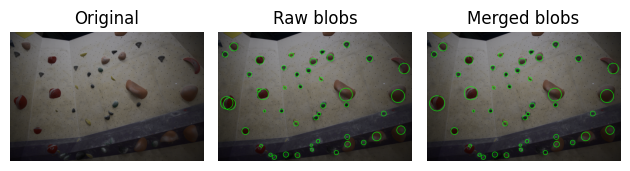

In [8]:
from std.utils import *
from matplotlib import pyplot as plt


img = cv.imread('data/sm/298.jpg')

# blob detection
keypoints = detect_blobs(img)
img_blobs = img.copy()
draw_keypoints(img_blobs, keypoints)

# merge blobs that have an overlapping
keypoints = merge_blobs(keypoints)
img_blobs_merged = img.copy()
draw_keypoints(img_blobs_merged, keypoints)                                                     


# display the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_blobs[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Raw blobs')

ax3.imshow(img_blobs_merged[:, :, ::-1])
ax3.axis('off')
ax3.set_title('Merged blobs')

fig.tight_layout()
plt.show()

#### Edge detection

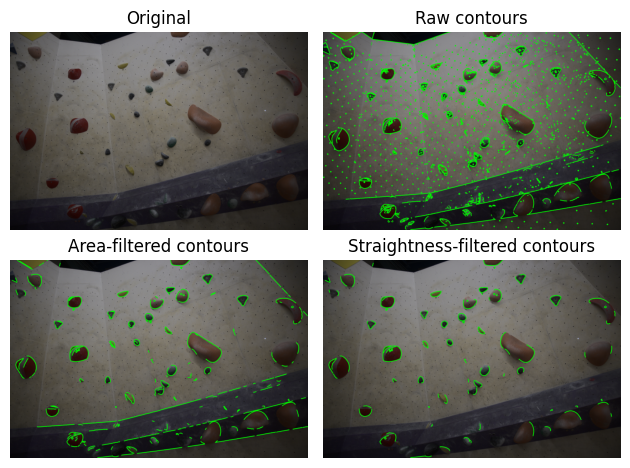

In [9]:
# blur the image for smoother edges
blur = gaussian_blur(img)

# find the contours
edges = canny(blur)
contours = find_contours(edges)

img_contours = img.copy()
draw_contours(img_contours, contours)

contours = filter_size_contours(contours)
img_contours_area = img.copy()
draw_contours(img_contours_area, contours)

contours = filter_straight_contours(contours)
img_contours_straight = img.copy()
draw_contours(img_contours_straight, contours)


# display the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_contours[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Raw contours')

ax3.imshow(img_contours_area[:, :, ::-1])
ax3.axis('off')
ax3.set_title('Area-filtered contours')

ax4.imshow(img_contours_straight[:, :, ::-1])
ax4.axis('off')
ax4.set_title('Straightness-filtered contours')

fig.tight_layout()
plt.show()

#### Combining the approaches

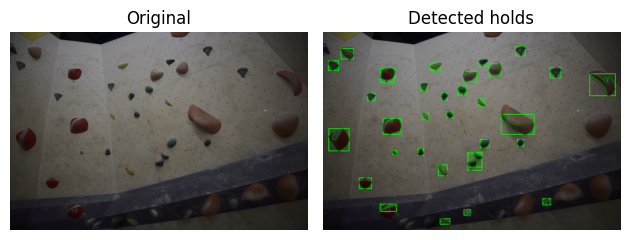

In [10]:
# contours are simplified to speed up the detection
contours = simplify_contours(contours)

# approximate holds by their contours
# returns a dictionary of keypoint-contour
# NOTE that this step can take a few minutes, depending on a number of keypoints
hold_approximations = detect_holds(img, keypoints, contours)

img_holds = img.copy()
draw_contour_boxes(img_holds, list(hold_approximations.values()), color=(0, 255, 0))
draw_contours(img_holds, list(hold_approximations.values()), color=(0, 128, 0))


# display the results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_holds[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Detected holds')

fig.tight_layout()
plt.show()

### Learning-based Approach

For this demo we load the config and weigths from the `Basic_Augmented_P2P3_DoubleTopK_NMS_2KIT` model and show the results on a sample image.

Weights and config can be downloaded from Kaggle https://www.kaggle.com/datasets/tomasslama/indoor-climbing-gym-hold-segmentation and must be placed in `ml/weights`

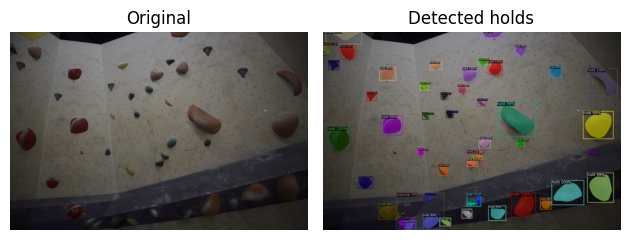

In [11]:
import cv2
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Get config and weigths for model
cfg = get_cfg()
cfg.merge_from_file("ml/weights/experiment_config.yml")
cfg.MODEL.WEIGHTS = "ml/weights/model_final.pth"
cfg.MODEL.DEVICE='cpu'
# Set metadata, in this case only the class names for plotting
MetadataCatalog.get("meta").thing_classes = ["hold", "volume"]
metadata = MetadataCatalog.get("meta")

predictor = DefaultPredictor(cfg)

img = cv2.imread("data/sm/298.jpg")
outputs = predictor(img)
v = Visualizer(
    img[:, :, ::-1],
    metadata=metadata
)

out_predictions = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img_holds = out_predictions.get_image()
# display the results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_holds)
ax2.axis('off')
ax2.set_title('Detected holds')

fig.tight_layout()
plt.show()

## Route Detection

### Standard Approach

Obtaining labbeled images via detectron2

In [1]:
import json
import os
from typing import List
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
%matplotlib inline

import detectron2.data.transforms as T
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode

def create_dataset_dicts(
    img_dir: str, annotation_filename: str = "annotation.json"
) -> List[dict]:
    annotation_json = os.path.join(img_dir, annotation_filename)
    with open(annotation_json, "r") as f:
        img_annotations = json.load(f)["_via_img_metadata"]
    dataset = []
    for id, image in enumerate(img_annotations.values()):
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        record = {}
        image_filename = os.path.join(img_dir, image["filename"])
        height, width = cv2.imread(image_filename).shape[:2]

        # Create dataset dict according to detectron2 dataset specification
        # https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts

        record["file_name"] = image_filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = id

        annotation_objects = []
        for annotation in image["regions"]:
            anno = annotation["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            # Merge point lists and flatten to [x_1, y_1, ..., x_n y_n] format
            polygons = [(x, y) for (x, y) in zip(px, py)]
            polygons = np.ravel(polygons).tolist()
            annotation_obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [polygons],
                "category_id": 0,  # We only have one category
            }
            annotation_objects.append(annotation_obj)
        record["annotations"] = annotation_objects
        dataset.append(record)
    return dataset

for dataset_type in ["test"]:
    DatasetCatalog.register(
        f"hold_{dataset_type}",
        lambda d=dataset_type: create_dataset_dicts(f"../cv final/cv-bh-data/{d}"),
    )
    MetadataCatalog.get(f"hold_{dataset_type}").thing_classes = ["hold"]
hold_metadata_test = MetadataCatalog.get("hold_test")

dataset_dicts = create_dataset_dicts("../cv final/cv-bh-data/train")
d_dict = dataset_dicts[0]
image = cv2.imread(d_dict["file_name"])
v = Visualizer(
    image[:, :, ::-1],
    metadata=hold_metadata_test,
    scale=0.5,
)

Creating binary image and finding contours of holds

In [2]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
points = np.array([[0,0],[d_dict["width"]-1,0],[d_dict["width"]-1,d_dict["height"]-1],[0,d_dict["height"]-1]])

cv2.fillPoly(gray,np.int32([points]),(0,0,0))
for poly in d_dict["annotations"]:
    p=np.array(poly["segmentation"])
    points = np.reshape(p,[int(p.shape[1]/2),2])
    cv2.fillPoly(gray,np.int32([points]),(255,255,255))
mask = gray

contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Clustering for Mean colors

(-0.5, 44799.5, 3727.5, -0.5)

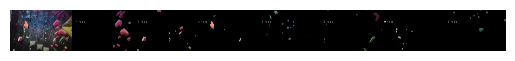

In [12]:
df_mean_color = pd.DataFrame()
for idx, contour in enumerate(contours):
    # get mean color of contour:
    masked = np.zeros_like(image[:, :, 0])  # This mask is used to get the mean color of the specific bead (contour), for kmeans
    cv2.drawContours(masked, [contour], 0, 255, -1)

    B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
    df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
    df_mean_color = pd.concat([df_mean_color, df])

df_mean_color2 = df_mean_color

km = KMeans( n_clusters=7, n_init="auto")
df_mean_color['label'] = km.fit_predict(df_mean_color)

def draw_segmented_objects(image, contours, label_cnt_idx, holds_count):
    mask = np.zeros_like(image[:, :, 0])
    cv2.drawContours(mask, [contours[i] for i in label_cnt_idx], -1, (255), -1)
    masked_image = cv2.bitwise_and(image, image, mask=mask)
    masked_image = cv2.putText(masked_image, f'{holds_count} holds', (200, 1200), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale = 7, color = (255, 255, 255), thickness = 15, lineType = cv2.LINE_AA)
    return masked_image

img = image.copy()
for label, df_grouped in df_mean_color.groupby('label'):
    holds_amount = len(df_grouped)
    masked_image = draw_segmented_objects(image, contours, df_grouped.index, holds_amount)
    img = cv2.hconcat([img, masked_image])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
plt.axis('off')

Clustering for Color moments

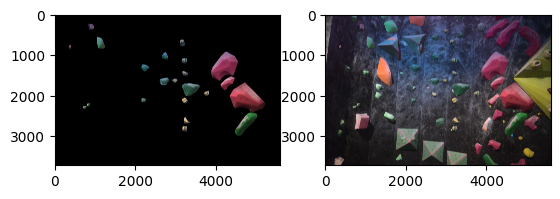

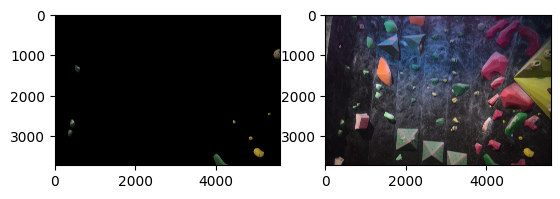

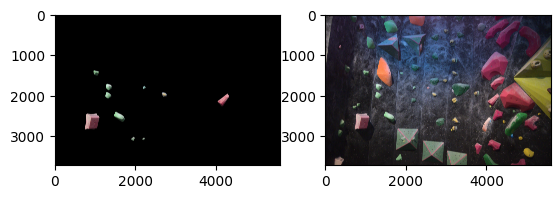

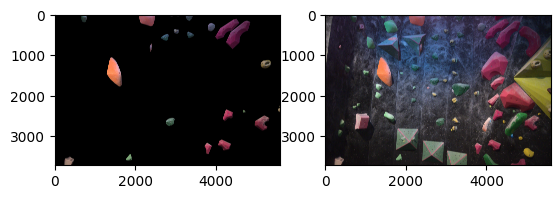

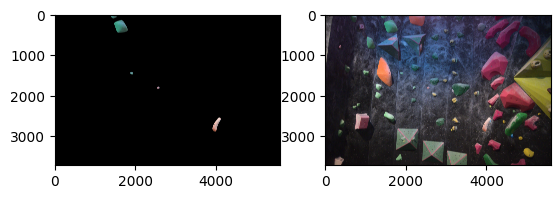

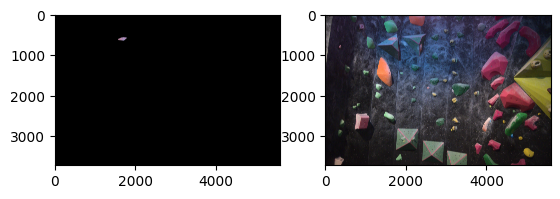

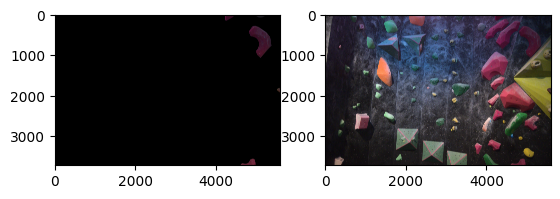

In [15]:
from collections import defaultdict

def plot_routes(routes: List, d_dict):
    image_bgr = cv2.imread(d_dict["file_name"])
    for k, holds in routes.items():
        height = d_dict["height"]
        width = d_dict["width"]
        final_bitmask = np.zeros((height, width))
        for hold_id in holds:
            hold_poly = d_dict["annotations"][hold_id]
            points = np.array(hold_poly["segmentation"])
            points = points.reshape((-1, 2)).astype(np.int32)
            points = points[np.newaxis, :]
            bitmask = cv2.fillPoly(np.zeros(image_bgr.shape[:2]), points, 255).astype(
                np.uint8
            )
            final_bitmask = final_bitmask + bitmask
        final_bitmask = final_bitmask.astype(np.bool8).astype(np.float32)
        img = image_bgr.transpose((2, 0, 1))
        masked_output = img * final_bitmask
        img_routes = masked_output.astype(np.int32).transpose((1, 2, 0))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(img_routes[:, :, ::-1])
        ax[1].imshow(image_bgr[:, :, ::-1])

# Masked versions of color moments https://en.wikipedia.org/wiki/Color_moments
def masked_skewness(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return skew(image_raveled, axis=1)


def masked_kurtosis(image, mask):
    np_image = np.transpose(image, (2, 0, 1)).astype("float64")
    mask_3 = np.array([mask, mask, mask])
    np_mask = np.ma.make_mask(mask_3)
    np_image = np.ma.array(np_image, mask=np_mask)
    image_raveled = np.ma.reshape(np_image, (3, -1))
    return kurtosis(image_raveled, axis=1)

color_moments = defaultdict(list)
for idx, poly in enumerate(d_dict["annotations"]):
    if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
        continue
    points = np.array(poly["segmentation"])
    points = points.reshape((-1, 2)).astype(np.int32)
    points = points[np.newaxis, :]
    mask = cv2.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
    mean_v, std_v = cv2.meanStdDev(image, mask=mask)
    # skew_v = masked_skewness(image, mask)
    # kurtosis_v = masked_kurtosis(image, mask)
    color_moments[idx].extend(mean_v[0:1, 0])
    color_moments[idx].extend(std_v[0:1, 0])
    # color_moments[idx].extend(skew_v[0:3])
    # color_moments[idx].extend(kurtosis_v[0:3])

color_moment_arr = np.array(list(color_moments.values()))
color_moments_arr_norm = color_moment_arr - np.mean(color_moment_arr, axis=0)
color_moments_arr_norm = color_moments_arr_norm / np.std(color_moments_arr_norm, axis=0)

clustering_input = color_moments_arr_norm  # color_moment_arr
km_moments = KMeans(n_clusters=7, random_state=42, n_init="auto")

km_moments.fit_predict(clustering_input)

routes = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km_moments.labels_):
    routes[cluster].append(id)

plot_routes(routes, d_dict)

Clustering for Histograms

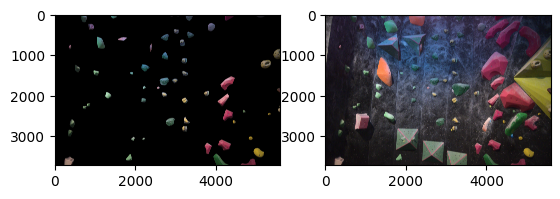

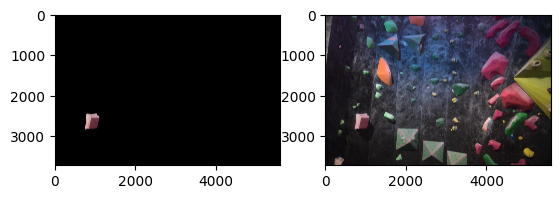

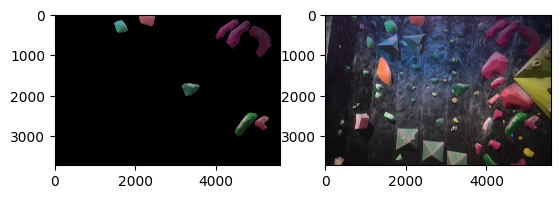

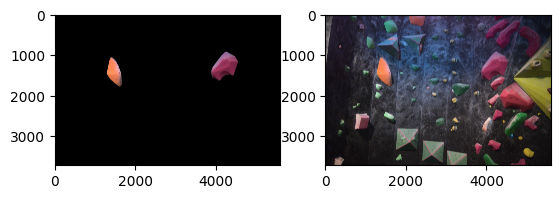

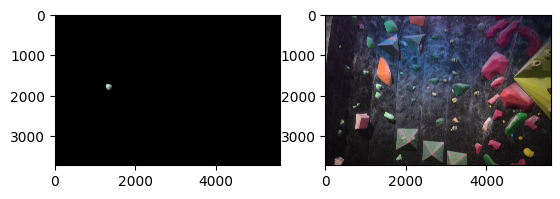

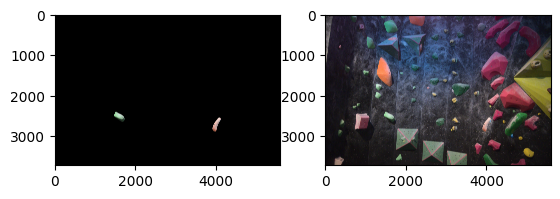

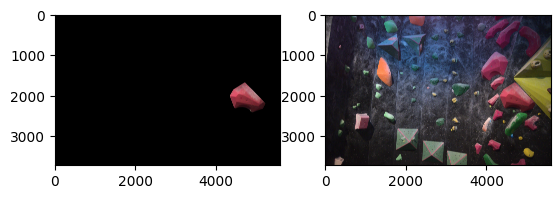

In [16]:
histograms = defaultdict(list)
for idx, poly in enumerate(d_dict["annotations"]):
    if poly["category_id"] == 1:
        # Volumes are considered part of the wall, not part of a route -> skip
        continue
    points = np.array(poly["segmentation"])
    points = points.reshape((-1, 2)).astype(np.int32)
    points = points[np.newaxis, :]
    mask = cv2.fillPoly(np.zeros(image.shape[:2]), points, 255).astype(np.uint8)
    hist0 = cv2.calcHist([image], [0], mask=mask, histSize=[256], ranges=[0, 256])
    hist1 = cv2.calcHist([image], [1], mask=mask, histSize=[256], ranges=[0, 256])
    hist2 = cv2.calcHist([image], [2], mask=mask, histSize=[256], ranges=[0, 256])
    hist = np.array([hist0])
    histograms[idx] = hist.flatten()

histograms_arr = np.array(list(histograms.values()))
histograms_arr_norm = histograms_arr - np.mean(histograms_arr, axis=0)
histograms_arr_norm = np.nan_to_num(
    histograms_arr_norm / np.std(histograms_arr_norm, axis=0)
)

clustering_input = histograms_arr_norm  # histograms_arr
km_histogram = KMeans(n_clusters=7, random_state=42, n_init="auto")

km_histogram.fit_predict(clustering_input)

routes = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km_histogram.labels_):
    routes[cluster].append(id)

plot_routes(routes, d_dict)

### Learning-based Approach

In [1]:
import cv2
import torch
import random
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from ml.route_networks import TripletNet
from collections import defaultdict
from ml.utils import plot_routes_instances, instance_to_hold
random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get config and weigths for model
cfg = get_cfg()
cfg.merge_from_file("ml/weights/experiment_config.yml")
cfg.MODEL.WEIGHTS = "ml/weights/model_final.pth"
cfg.MODEL.DEVICE='cpu'
# Set metadata, in this case only the class names for plotting
MetadataCatalog.get("meta").thing_classes = ["hold", "volume"]
metadata = MetadataCatalog.get("meta")

predictor = DefaultPredictor(cfg)

img = cv2.imread("data/sm/298.jpg")
# Get holds
outputs = predictor(img)

# Load weigths for TripletNet
triplet_model = TripletNet().to(device)
triplet_model.load_state_dict(torch.load("ml/weights/triplet_network_final.pt"))

/home/philipp/anaconda3/envs/cv_final/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

defaultdict(<class 'list'>, {0: [40, 1, 4, 6, 8, 9, 18, 24, 26, 28, 29, 32, 33, 35, 37, 40], 1: [0, 2, 3, 5, 10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 30, 31, 34, 38, 41, 42], 2: [7, 16], 3: [17], 4: [25, 27], 5: [36, 39]})


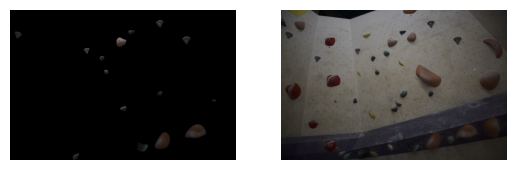

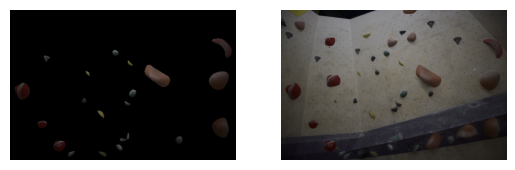

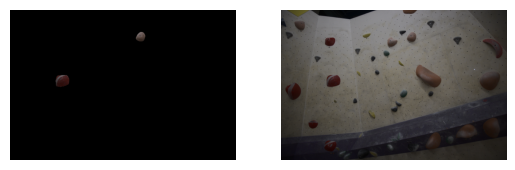

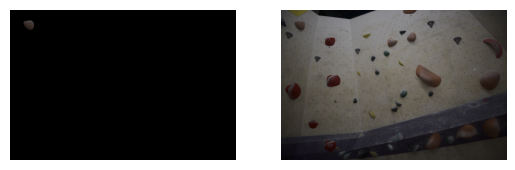

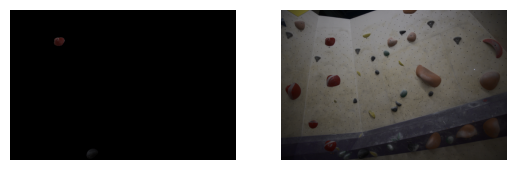

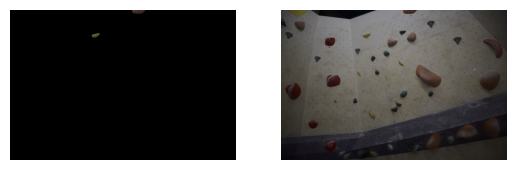

In [2]:
instances = outputs["instances"]
# Filter to only include holds with scorces > 0.7
instances = instances[instances.pred_classes == 0]
instances = instances[instances.scores > 0.7]

# Initialize routes with random seed hold
routes_dict = defaultdict(list)
routes_dict[0] = [random.randint(0,len(instances)-1)]

for hold_idx in range(len(instances)):
    for route_id, holds in routes_dict.items():
        dists = []
        for route_hold_idx in holds:
            with torch.no_grad():
                input1 = instance_to_hold(instances[hold_idx], img, triplet_model.preprocess ,device).unsqueeze(0)
                input2 = instance_to_hold(instances[route_hold_idx], img, triplet_model.preprocess, device).unsqueeze(0)
                output1 = triplet_model(input1)
                output2 = triplet_model(input2)
            dist = torch.nn.functional.pairwise_distance(output1, output2).square().item()
            dists.append(dist)
        if np.median(np.array(dists)) <= 0.7 and np.max(dists) <= 2.65:
            # Current hold is similar to all holds in existing route => Adding it to that route
            routes_dict[route_id].append(hold_idx)
            break
    else:
        # Current hold is not similar to any holds on existing routes => Add new route
        routes_dict[max(routes_dict.keys()) + 1].append(hold_idx)
print(routes_dict)

figures_axes = plot_routes_instances(routes_dict, instances, img)
for (fig, ax) in figures_axes:
    fig.canvas.draw()